# Exoplanet Convolutional Neural Network (CNN) Classifier
Here we will use a CNN to classify if a star observed by Kepler contains a exoplanet 

In [1]:
import tensorflow
import tensorflow.keras.models
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
print(f'Pandas version {pd.__version__}')
print(f'Tensorflow version {tensorflow.__version__}')
print(f'Scikit Learn version {sklearn.__version__}')

Pandas version 1.0.0
Tensorflow version 2.0.0-beta1
Scikit Learn version 0.21.3


First lets load the data and preprocess it.

In [3]:
def load_data(path):
    data = pd.read_csv(path)

    # Convert columns to something more useful.
    for i, column in enumerate(data.columns):
        if 'FLUX' in column:
            data.columns.values[i] = int(column.split('.')[1])
    # Also change labels so 0 is non-exoplanet and 1 is exoplanet
    data.LABEL -= 1
    return data

def normalize_data(df):
    """
    Normalize a Kepler light curve DatFrame with a mean subtraction and 
    """
    # Calculate the mean of each light curve and subtract it
    df_norm = df.copy()
    mean = df_norm.iloc[:, 1:].mean(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].subtract(mean, axis=0)
    # Calculate the standard deviation of each light curve and divide.
    std = df_norm.iloc[:, 1:].std(axis=1)
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:].divide(std, axis=0)
    return df_norm


train_data = load_data('./data/exoTrain.csv')
train_data = normalize_data(train_data)

test_data = load_data('./data/exoTest.csv')
test_data = normalize_data(test_data)

Now extract numpy arrays from Pandas and reshape the arrays to input into the CNN.

In [10]:
train_data_array = train_data.iloc[:, 1:].values
train_data_labels = train_data.iloc[:, 0].values

test_data_array = test_data.iloc[:, 1:].values
test_data_labels = test_data.iloc[:, 0].values

train_data_array = train_data_array.reshape(*train_data_array.shape, 1)
train_data_labels = train_data_labels.reshape(train_data_labels.shape[0], 1)
test_data_array = test_data_array.reshape(*test_data_array.shape, 1)
test_data_labels = test_data_labels.reshape(test_data_labels.shape[0], 1)

print(train_data_array.shape, train_data_labels.shape)
print(test_data_array.shape, test_data_labels.shape)

(5087, 3197, 1) (5087, 1)
(570, 3197, 1) (570, 1)


To ballance the data set we create a batch function to return equal number of exoplanet and non-exoplanet light curves. There will be duplicate light curves.

In [11]:
def light_curve_batch_generator(x, y, batch_size=32, augmentation='shift'):
    """
    Returns batch_size number of random exoplanets and non-exoplanet detections.
    """
    idx_exo = np.where(y==1)[0]
    idx_nonexo = np.where(y==0)[0]
 
    while True:
        # Randomly pick half exoplanets and half non-exoplanets
        random_idx_exo = np.random.choice(idx_exo, size=batch_size//2, replace=True)
        random_idx_nonexo = np.random.choice(idx_nonexo, size=batch_size//2, replace=True)
        random_idx = np.concatenate((random_idx_exo, random_idx_nonexo))
        np.random.shuffle(random_idx)
        train_data = x[random_idx, :, :]
        train_labels = y[random_idx, :]

        if augmentation == 'shift':
            # Shift each lightcurve by a random index. This is one augmentation technique 
            # to increase the number of observations but will have discontinuities. This 
            # helps the CNN learn better.
            for i in range(batch_size):
                random_shift = np.random.randint(train_data.shape[1])
                train_data[i] = np.roll(train_data[i], random_shift, axis=0)
        if augmentation == 'noise':
            # Another augmentation technique to add Gaussian noise to each light curve.
            # Does not work as well as the shift augmentation. Can you think of another 
            # method? 
            train_data = np.random.normal(loc=train_data, scale=0.5)
        yield train_data, train_labels

Test the batch generator

In [13]:
batch_gen = light_curve_batch_generator(train_data_array, train_data_labels)

for _ in range(3):
    print(next(batch_gen))

(array([[[-1.15228191e+00],
        [-1.71486553e-01],
        [-2.00383470e-01],
        ...,
        [-9.39804582e-01],
        [-1.90184558e-01],
        [-2.64976578e-01]],

       [[ 5.98188966e-01],
        [ 3.33570919e-01],
        [ 7.94819505e-01],
        ...,
        [-2.16661318e-01],
        [ 3.68231217e-01],
        [ 6.24684098e-01]],

       [[ 4.59843699e-02],
        [-1.83342337e-01],
        [-2.43516819e-01],
        ...,
        [-1.97482389e-01],
        [-2.09487695e-01],
        [-2.69207298e-03]],

       ...,

       [[ 2.07886653e-01],
        [ 5.81629464e+00],
        [ 8.58362655e-01],
        ...,
        [ 7.40536912e-01],
        [-4.28469735e-01],
        [ 7.64281798e-02]],

       [[-4.30033987e-01],
        [-6.76585092e-02],
        [-3.98246665e-01],
        ...,
        [ 4.25044992e-01],
        [ 4.97096257e-01],
        [ 1.05052611e-01]],

       [[ 1.42280903e-01],
        [-3.93907677e-01],
        [-1.01669500e+00],
        ...,
       

In [19]:
def cnn_model(norm='False'):
    """ 
    Describe the CNN model architecture here and compile it.
    """
    model = tensorflow.keras.models.Sequential()

    ### LAYER ###
    # Note that the input_shape = (Number of time steps, 1) so is only
    # one light curve.
    model.add(Conv1D(filters=8, kernel_size=25, activation='relu', 
                    input_shape=train_data_array.shape[1:]))
    model.add(MaxPooling1D(strides=4))
    if norm:
        model.add(BatchNormalization()) # Normalize to mean=0 and std=1

    ### LAYER ###
    model.add(Conv1D(filters=16, kernel_size=25, activation='relu'))
    model.add(MaxPooling1D(strides=4))
    if norm:
        model.add(BatchNormalization()) # Normalize to mean=0 and std=1

    ### LAYER ###
    # model.add(Conv1D(filters=32, kernel_size=25, activation='relu'))
    # model.add(MaxPooling1D(strides=4))
    # if norm:
    #     model.add(BatchNormalization()) # Normalize to mean=0 and std=1

    ### LAYER ###
    # model.add(Conv1D(filters=64, kernel_size=25, activation='relu'))
    # model.add(MaxPooling1D(strides=4))
    
    # Flattens the array of n_filters number of 1D feature maps from the convolution.
    model.add(Flatten()) 

    # Dropout determines the fraction of the input units to drop. This reduces overfitting 
    # https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout
    # model.add(Dropout(0.5)) 

    ### NORMAL NEURAL NETWORK ###
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile and optimize the model
    model.compile(optimizer=Adam(4e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
norm = False
model = cnn_model(norm=norm)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 3173, 8)           208       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 793, 8)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 793, 8)            32        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 769, 16)           3216      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 192, 16)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 192, 16)           64        
_________________________________________________________________
flatten (Flatten)            (None, 3072)             

Now train the model

In [21]:
hist = model.fit(x=light_curve_batch_generator(train_data_array, train_data_labels), 
                validation_data=(test_data_array, test_data_labels), 
                verbose=2, epochs=60, steps_per_epoch=train_data_array.shape[0]//32)

Epoch 1/60
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
158/158 - 14s - loss: 0.7020 - accuracy: 0.5759 - val_loss: 0.6707 - val_accuracy: 0.6404
Epoch 2/60
158/158 - 10s - loss: 0.6401 - accuracy: 0.6319 - val_loss: 0.5194 - val_accuracy: 0.7912
Epoch 3/60
158/158 - 10s - loss: 0.5929 - accuracy: 0.6790 - val_loss: 0.4628 - val_accuracy: 0.8123
Epoch 4/60
158/158 - 11s - loss: 0.5499 - accuracy: 0.7128 - val_loss: 0.4574 - val_accuracy: 0.7930
Epoch 5/60
158/158 - 11s - loss: 0.5168 - accuracy: 0.7429 - val_loss: 0.4120 - val_accuracy: 0.8193
Epoch 6/60
158/158 - 11s - loss: 0.4747 - accuracy: 0.7743 - val_loss: 0.3855 - val_accuracy: 0.8351
Epoch 7/60
158/158 - 10s - loss: 0.4380 - accuracy: 0.8026 - val_loss: 0.3605 - val_accuracy: 0.8509
Epoch 8/60
158/158 - 10s - loss: 0.4158 - accuracy: 0.8188 - val_loss: 0.3543 - val_accuracy: 0.8526
Epoch 9/60
158/158 - 10s - loss: 0.3680 - accuracy: 0.8441 - val_loss: 0.3310 - val_accuracy: 0.85

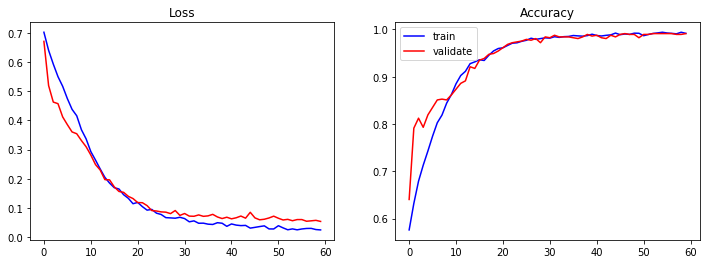

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(hist.history['loss'], color='b')
ax[0].plot(hist.history['val_loss'], color='r')
ax[1].plot(hist.history['accuracy'], color='b', label='train')
ax[1].plot(hist.history['val_accuracy'], color='r', label='validate')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[1].legend();

# if norm:
#     plt.savefig('cnn_with_batch_normalization.png')
# else:
#     plt.savefig('cnn_without_batch_normalization.png')

What is the model's final loss and accuracy?

In [23]:
model.evaluate(test_data_array, test_data_labels, verbose=1)

570/570 [==============================] - 0s 756us/sample - loss: 0.0546 - accuracy: 0.9912


[0.054606266375406436, 0.99122804]

What probability of exoplanet does this CNN predict for exoplanets and nonexoplenets test light curves?

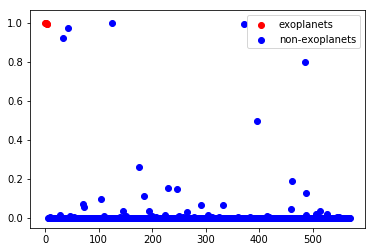

In [24]:
exo_idx = np.where(test_data_labels == 1)[0]
nonexo_idx = np.where(test_data_labels == 0)[0]
cnn_predict = model.predict(test_data_array)

plt.scatter(exo_idx, cnn_predict[exo_idx].flatten(), c='r', label='exoplanets')
plt.scatter(nonexo_idx, cnn_predict[nonexo_idx].flatten(), c='b', label='non-exoplanets')
plt.legend();

Exoplanets are assigned a high probability, > 0.8, while most non-exoplanet light curves are assigned a probability near 0. So far so good! So if we were to hand this trained CNN to the Kepler scientists, what probability threshold should we tell them to use? 

To quanity this question we will use the Receiver operating characteristic (ROC) curve to quantify the "best" tradeoff between false-positives and true-positive classifications.

In [25]:
def roc_curve(true_labels, predicted_prob, thresh=np.linspace(0,1)):
    """ 
    Calculates the ROC curve, the ratio of true-positive
    to false-positive detections given a threshold for a
    series of thresholds.
    
    Parameters
    ----------
    true_labels : array
        Array containing the true test labels. 1 is assumed to be true and
        0 is false.
    predicted_prob : array
        Array containing the predicted probabilities between 0 and 1
    thresh : array, optional
        Array containing thresholds to evaluate the ROC curve.

    Returns
    -------
    thresh : array
        Array containing the threshold values used.
    roc : array
        Array contaning the ROC values.
    """ 
    raise NotImplementedError
    roc = np.nan*np.ones_like(thresh)

    for i, thresh_i in enumerate(thresh):
        predicted_labels = np.zeros_like(true_labels)
        predicted_labels[predicted_prob > thresh_i] = 1

        tpr = 1
        fpr = 2
        roc[i] = tp/fp
    
    return thresh, roc

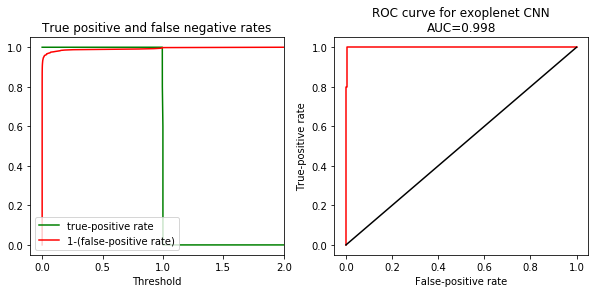

In [25]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_data_labels, cnn_predict, drop_intermediate=False)
auc = sklearn.metrics.auc(fpr, tpr)

_, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(thresholds, tpr, 'g', label='true-positive rate')
ax[0].plot(thresholds, 1-fpr, 'r', label='1-(false-positive rate)')
ax[0].set(xlabel='Threshold', xlim=(-0.1, 2), title='True positive and false negative rates')
ax[0].legend(loc=3)
ax[1].plot(fpr, tpr, 'r')
ax[1].plot(np.linspace(0, 1), np.linspace(0, 1), 'k')
ax[1].set(title=f'ROC curve for exoplenet CNN\nAUC={round(auc, 3)}', 
            xlabel='False-positive rate', ylabel='True-positive rate');

The point at (0, 1) on the ROC curve plot represent a perfect model since there it as 100% true-positive rate and 0% false-positive rate. This model is good, but not perfect. The optimal threshold is the threshold where the ROC curve is closest to (0, 1). Lets calculate that.

In [26]:
arr = np.array([tpr, fpr]).T
roc_curve = np.array(sorted(arr, key=lambda x: x[1]))

In [27]:
optimal_point_arr = np.array([np.zeros(len(roc_curve)), np.ones(len(roc_curve))]).T
roc_cure_array = np.array([fpr, roc_curve[:,0]]).T
d = np.linalg.norm(optimal_point_arr - roc_cure_array, axis=1)
optimal_threshold = thresholds[np.nanargmin(d)]
print(f'The optimal classification threshold for this CNN is {optimal_threshold}')

The optimal classification threshold for this CNN is 0.9948235750198364


In [36]:
cnn_predict[exo_idx].flatten() > optimal_threshold

array([ True,  True,  True, False,  True])

In [38]:
cnn_predict[nonexo_idx[:100]].flatten() > optimal_threshold

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])